In [3]:
import pandas as pd
from sklearn.neighbors import BallTree
import numpy as np

# Load the datasets
housing_data = pd.read_csv('housing.csv')
cities_data = pd.read_csv('cal_cities_lat_long.csv')
city_population_data = pd.read_csv('cal_populations_city.csv')


# Display the first few rows of each dataset to understand their structure
housing_data.head(), cities_data.head()

# Convert degrees to radians for latitude and longitude for more accurate distance calculations
housing_data['latitude_rad'] = np.radians(housing_data['latitude'])
housing_data['longitude_rad'] = np.radians(housing_data['longitude'])
cities_data['Latitude_rad'] = np.radians(cities_data['Latitude'])
cities_data['Longitude_rad'] = np.radians(cities_data['Longitude'])

# Create arrays of the coordinates
housing_coords = housing_data[['latitude_rad', 'longitude_rad']].values
city_coords = cities_data[['Latitude_rad', 'Longitude_rad']].values

# Use BallTree to find the nearest city to each house
tree = BallTree(city_coords, metric='haversine')
distances, indices = tree.query(housing_coords, k=1)

# Add nearest city name to the housing data
housing_data['nearest_city'] = cities_data.iloc[indices.flatten()]['Name'].values
housing_data[['latitude', 'longitude', 'nearest_city']].head()

# Filter cities with population greater than 400,000 in April 1990
big_cities = city_population_data[city_population_data['pop_april_1990'] > 300000]

# We'll need the latitude and longitude for these big cities, so let's merge this data with the city coordinates
big_cities = big_cities.merge(cities_data, left_on='City', right_on='Name')

# Convert the latitudes and longitudes of big cities to radians for distance calculation
big_cities['Latitude_rad'] = np.radians(big_cities['Latitude'])
big_cities['Longitude_rad'] = np.radians(big_cities['Longitude'])

# Create an array of the coordinates for big cities
big_city_coords = big_cities[['Latitude_rad', 'Longitude_rad']].values

# Use BallTree to find the nearest big city to each house
big_tree = BallTree(big_city_coords, metric='haversine')
big_distances, big_indices = big_tree.query(housing_coords, k=1)  # k=1 means find the nearest

# Add nearest big city name to the housing data
housing_data['nearest_big_city'] = big_cities.iloc[big_indices.flatten()]['City'].values
housing_data[['latitude', 'longitude', 'nearest_city', 'nearest_big_city']]

,latitude,longitude,nearest_city,nearest_big_city
0,37.88,-122.23,Berkeley,Oakland
1,37.86,-122.22,Orinda,Oakland
2,37.85,-122.24,Piedmont,Oakland
3,37.85,-122.25,Berkeley,Oakland
4,37.85,-122.25,Berkeley,Oakland
...,...,...,...,...
20635,39.48,-121.09,Nevada City,Sacramento
20636,39.49,-121.21,Oroville,Sacramento
20637,39.43,-121.22,Nevada City,Sacramento
20638,39.43,-121.32,Oroville,Sacramento


In [4]:
def haversine_distance(lat1, lon1, lat2, lon2):
    # Radius of the Earth in kilometers
    R = 6371.0
    # Differences in coordinates
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    # Haversine formula
    a = np.sin(dlat / 2)**2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# Correctly fetch latitude and longitude for the nearest big cities
nearest_big_city_lats = big_cities.loc[big_indices.flatten(), 'Latitude'].to_numpy()
nearest_big_city_lons = big_cities.loc[big_indices.flatten(), 'Longitude'].to_numpy()

# Calculate distances using the numpy arrays for coordinates
housing_data['distance_to_nearest_big_city_km'] = np.vectorize(haversine_distance)(
    np.radians(housing_data['latitude']),
    np.radians(housing_data['longitude']),
    np.radians(nearest_big_city_lats),
    np.radians(nearest_big_city_lons)
)

# Show the results
print(housing_data[['latitude', 'longitude', 'nearest_big_city', 'distance_to_nearest_big_city_km']])

       latitude  longitude nearest_big_city  distance_to_nearest_big_city_km
0         37.88    -122.23          Oakland                         0.167070
1         37.86    -122.22          Oakland                         0.146619
2         37.85    -122.24          Oakland                         0.107190
3         37.85    -122.25          Oakland                         0.097585
4         37.85    -122.25          Oakland                         0.097585
...         ...        ...              ...                              ...
20635     39.48    -121.09       Sacramento                         1.912064
20636     39.49    -121.21       Sacramento                         1.847369
20637     39.43    -121.22       Sacramento                         1.730523
20638     39.43    -121.32       Sacramento                         1.680981
20639     39.37    -121.24       Sacramento                         1.607787

[20640 rows x 4 columns]


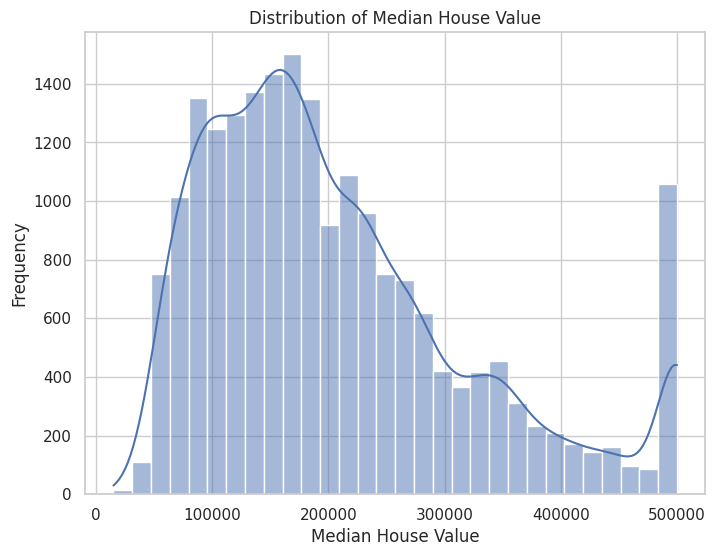

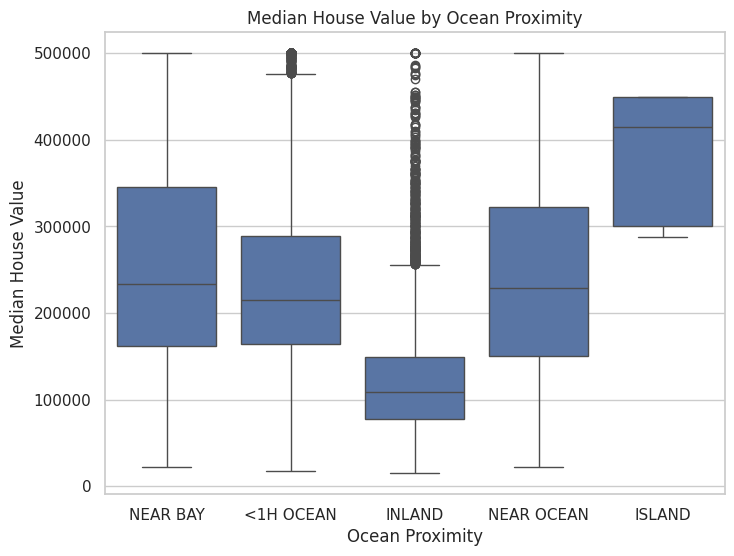

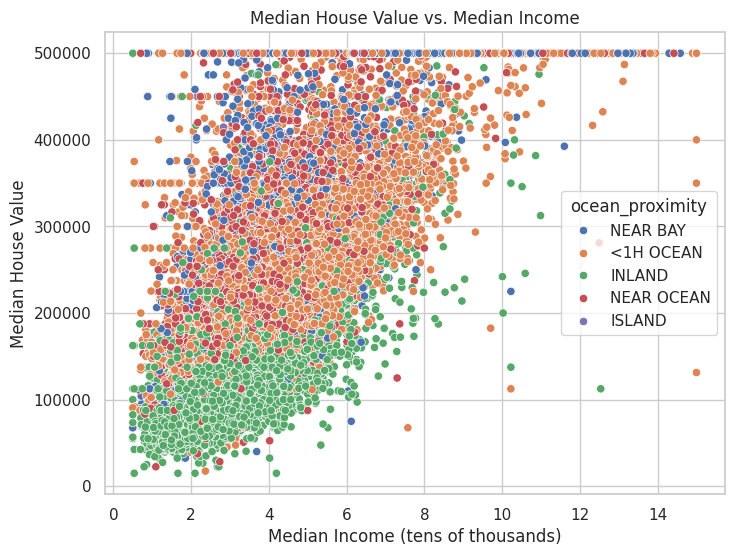

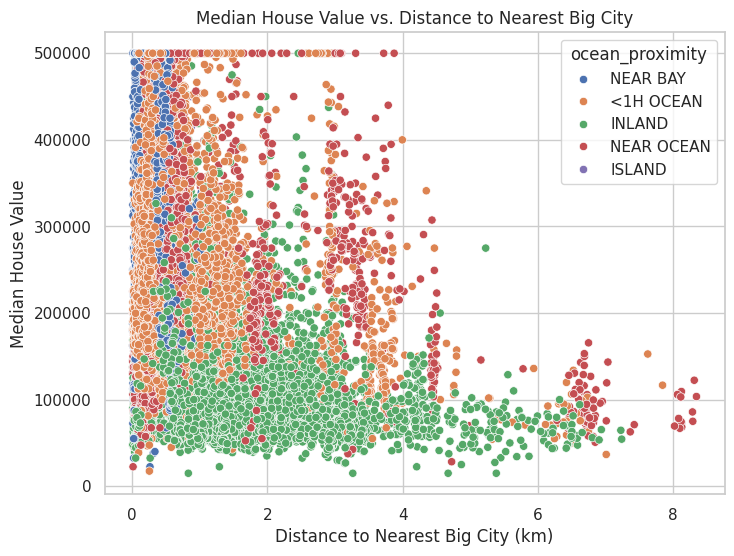

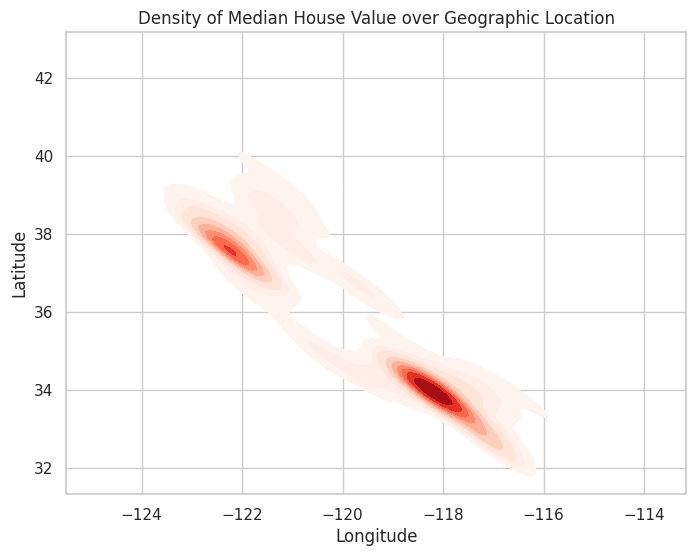

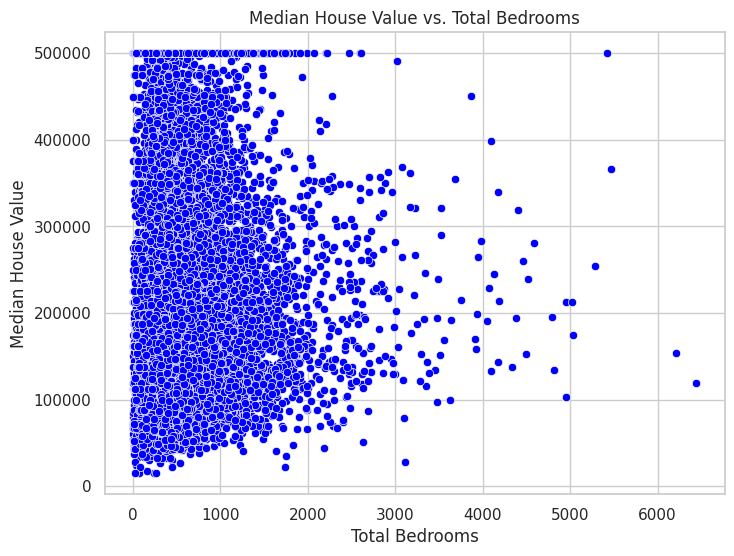

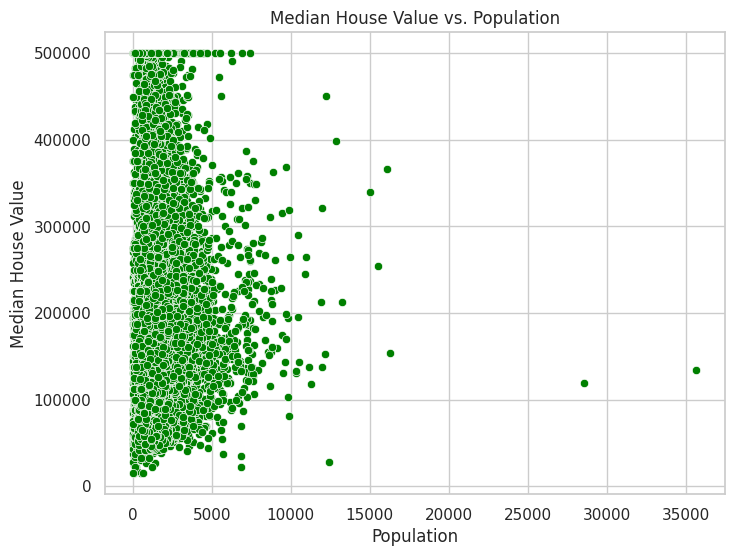

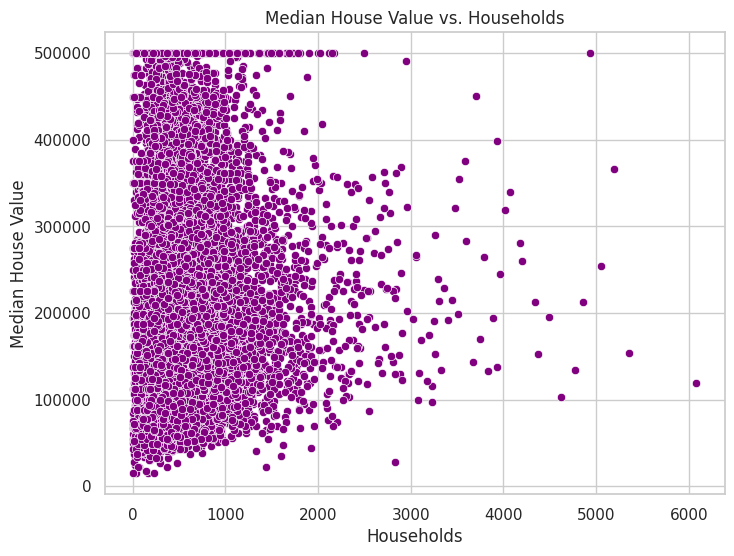

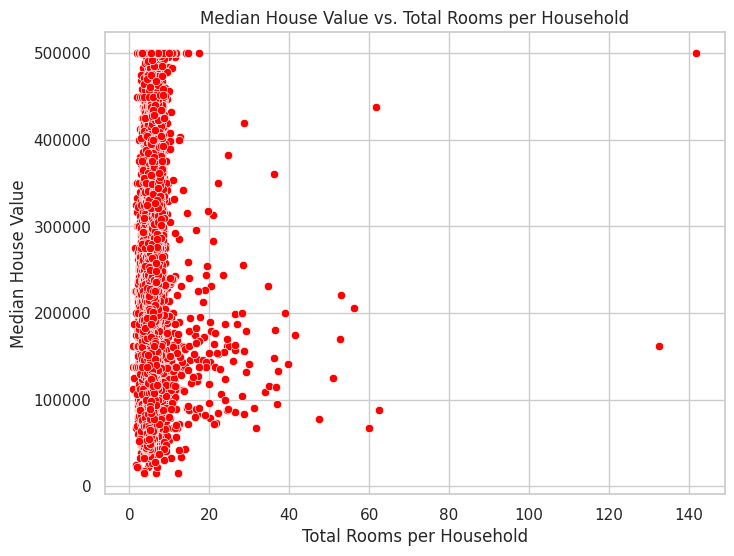

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Histogram of median house values
fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(housing_data['median_house_value'], bins=30, kde=True, ax=ax)
ax.set_title('Distribution of Median House Value')
ax.set_xlabel('Median House Value')
ax.set_ylabel('Frequency')
plt.show()

# Box plot of median house values by ocean proximity
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x='ocean_proximity', y='median_house_value', data=housing_data, ax=ax)
ax.set_title('Median House Value by Ocean Proximity')
ax.set_xlabel('Ocean Proximity')
ax.set_ylabel('Median House Value')
plt.show()

# Scatter plot of median house value vs. median income
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(x='median_income', y='median_house_value', hue='ocean_proximity', data=housing_data, ax=ax)
ax.set_title('Median House Value vs. Median Income')
ax.set_xlabel('Median Income (tens of thousands)')
ax.set_ylabel('Median House Value')
plt.show()

# Scatter plot of median house value vs. distance to nearest big city
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(x='distance_to_nearest_big_city_km', y='median_house_value', hue='ocean_proximity', data=housing_data, ax=ax)
ax.set_title('Median House Value vs. Distance to Nearest Big City')
ax.set_xlabel('Distance to Nearest Big City (km)')
ax.set_ylabel('Median House Value')
plt.show()

# Density of Median House Value over Geographic Location
fig, ax = plt.subplots(figsize=(8, 6))
sns.kdeplot(x=housing_data['longitude'], y=housing_data['latitude'], weights=housing_data['median_house_value'], cmap="Reds", fill=True, ax=ax)
ax.set_title('Density of Median House Value over Geographic Location')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

# Scatter plot of Median House Value vs. Total Bedrooms
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(x='total_bedrooms', y='median_house_value', data=housing_data, ax=ax, color='blue')
ax.set_title('Median House Value vs. Total Bedrooms')
ax.set_xlabel('Total Bedrooms')
ax.set_ylabel('Median House Value')
plt.show()

# Scatter plot of Median House Value vs. Population
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(x='population', y='median_house_value', data=housing_data, ax=ax, color='green')
ax.set_title('Median House Value vs. Population')
ax.set_xlabel('Population')
ax.set_ylabel('Median House Value')
plt.show()

# Scatter plot of Median House Value vs. Households
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(x='households', y='median_house_value', data=housing_data, ax=ax, color='purple')
ax.set_title('Median House Value vs. Households')
ax.set_xlabel('Households')
ax.set_ylabel('Median House Value')
plt.show()

# Scatter plot of Median House Value vs. Total Rooms per Household
fig, ax = plt.subplots(figsize=(8, 6))
housing_data['rooms_per_household'] = housing_data['total_rooms'] / housing_data['households']
sns.scatterplot(x='rooms_per_household', y='median_house_value', data=housing_data, ax=ax, color='red')
ax.set_title('Median House Value vs. Total Rooms per Household')
ax.set_xlabel('Total Rooms per Household')
ax.set_ylabel('Median House Value')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# Assuming 'housing_data' is your DataFrame and 'median_house_value' is the target
X = housing_data.drop('median_house_value', axis=1)
y = housing_data['median_house_value']
X = X.drop(['latitude', 'longitude', 'latitude_rad', 'longitude_rad', 'rooms_per_household'], axis=1)
X['lat_lon_interaction'] = housing_data['latitude'] * housing_data['longitude']


# Identify categorical and numeric columns (you may need to adjust these)
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Create transformers for numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine transformers into a preprocessor with ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Define the models
knn = KNeighborsRegressor()
rf = RandomForestRegressor()
ridge = Ridge()
ada = AdaBoostRegressor()

# Create pipelines for each model
knn_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', knn)])
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', rf)])
ridge_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('regressor', ridge)])
ada_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', ada)])

# Cross-validate the models
model_names = ['KNN', 'Random Forest', 'Ridge', 'AdaBoost']
models = [knn_pipeline, rf_pipeline, ridge_pipeline, ada_pipeline]

for name, model in zip(model_names, models):
    scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-scores)
    print(f"{name} RMSE: {np.mean(rmse_scores):.2f} (+/- {np.std(rmse_scores):.2f})")

KNN RMSE: 75730.74 (+/- 10092.51)
Random Forest RMSE: 73898.19 (+/- 9138.52)
Ridge RMSE: 72273.02 (+/- 7288.64)
AdaBoost RMSE: 91424.13 (+/- 11658.21)


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define a parameter grid to search over
param_grid = {
    'regressor__alpha': [1, 5, 10, 15, 20, 25, 30, 35]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(ridge_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

# Fit GridSearchCV
grid_search.fit(X, y)

# Best model
best_model = grid_search.best_estimator_

# Get the best alpha
best_alpha = grid_search.best_params_['regressor__alpha']
print(f"Best alpha: {best_alpha}")

# Evaluate the best model
best_scores = cross_val_score(best_model, X, y, cv=5, scoring='neg_mean_squared_error')
best_rmse_scores = np.sqrt(-best_scores)
print(f"Best Ridge RMSE: {np.mean(best_rmse_scores):.2f} (+/- {np.std(best_rmse_scores):.2f})")

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best alpha: 25
Best Ridge RMSE: 69325.17 (+/- 6992.00)


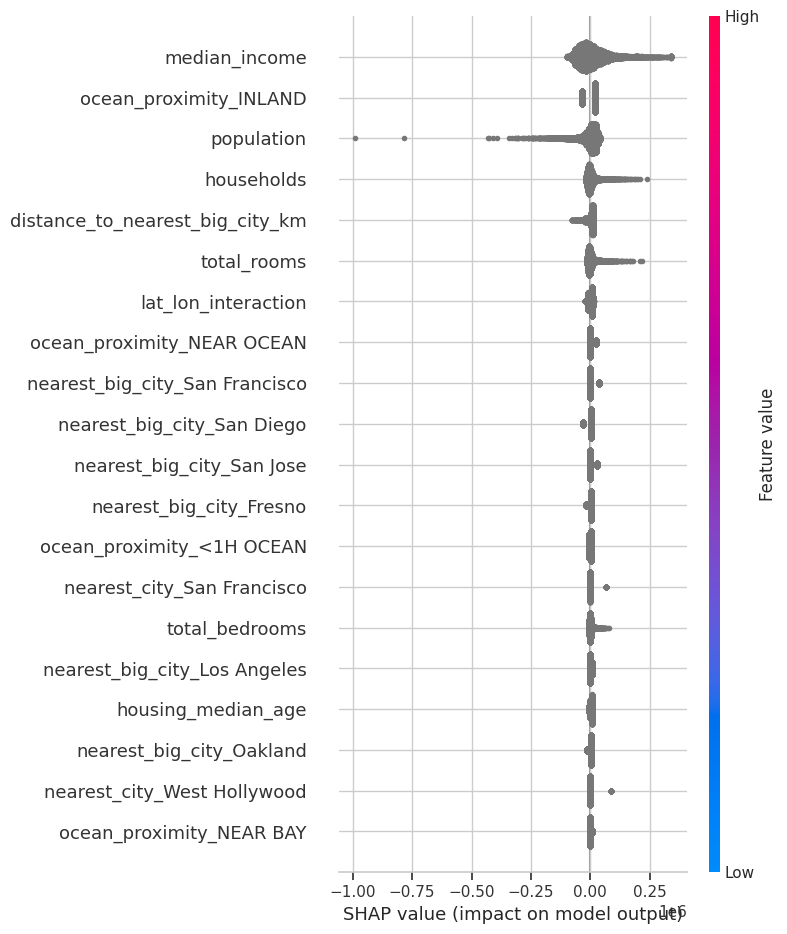

In [ ]:
import shap

# Fit the best model on the entire dataset
best_model.fit(X, y)

# We need to transform the data using the pipeline's preprocessor
X_transformed = best_model.named_steps['preprocessor'].transform(X)

# Create a function to get feature names from the ColumnTransformer
def get_feature_names(column_transformer):
    """Get feature names from all transformers."""
    new_feature_names = []

    # Loop over all transformers in the Column Transformer
    for transformer_item in column_transformer.transformers_:
        transformer_name, transformer, orig_features = transformer_item
        if transformer_name != 'remainder':
            if hasattr(transformer, 'get_feature_names_out'):
                features_out = transformer.get_feature_names_out(orig_features)
                new_feature_names.extend(features_out)
            else:
                new_feature_names.extend(orig_features)

    return new_feature_names

# Get the feature names after transformation
new_feature_names = get_feature_names(best_model.named_steps['preprocessor'])

# Initialize the SHAP explainer with the trained model
explainer = shap.Explainer(best_model.named_steps['regressor'], X_transformed)

# Calculate SHAP values
shap_values = explainer.shap_values(X_transformed)

# Summary plot of SHAP values
shap.summary_plot(shap_values, X_transformed, feature_names=new_feature_names)

In [ ]:
from sklearn.cluster import KMeans

# Number of clusters
n_clusters = 10  # This is arbitrary; you might want to use a method like the elbow rule to choose the right number

# Fit the KMeans model on the latitude and longitude
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
housing_data['location_cluster'] = kmeans.fit_predict(housing_data[['latitude', 'longitude']])

housing_data = pd.get_dummies(housing_data, columns=['location_cluster'], drop_first=True)

X = housing_data.drop('median_house_value', axis=1)
y = housing_data['median_house_value']

# Create a new pipeline with clustering
clustered_ridge_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                           ('regressor', ridge)])

# Cross-validate the clustered Ridge model
clustered_ridge_scores = cross_val_score(clustered_ridge_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
clustered_rmse_scores = np.sqrt(-clustered_ridge_scores)
print(f"Clustered Ridge RMSE: {np.mean(clustered_rmse_scores):.2f} (+/- {np.std(clustered_rmse_scores):.2f})")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Clustered Ridge RMSE: 71112.85 (+/- 5074.71)


In [5]:
cluster_data = housing_data.copy()
cluster_data = cluster_data.drop(['ocean_proximity','nearest_city','nearest_big_city','median_house_value'],axis=1)

In [6]:
for column in cluster_data.columns:
  print(column, cluster_data[column].isna().sum())

longitude 0
latitude 0
housing_median_age 0
total_rooms 0
total_bedrooms 207
population 0
households 0
median_income 0
latitude_rad 0
longitude_rad 0
distance_to_nearest_big_city_km 0


In [7]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
imp_cluster_data = imputer.fit_transform(cluster_data)

In [8]:
imp_cluster_data = pd.DataFrame(imp_cluster_data,columns=cluster_data.columns)

In [9]:
for column in imp_cluster_data.columns:
  print(column, imp_cluster_data[column].isna().sum())

longitude 0
latitude 0
housing_median_age 0
total_rooms 0
total_bedrooms 0
population 0
households 0
median_income 0
latitude_rad 0
longitude_rad 0
distance_to_nearest_big_city_km 0


In [10]:
# Let's try some clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

k_values = range(2,10)
wcss_scores = []
silhouette_scores = []
for k in k_values:
    kmeans = KMeans(n_clusters=k,random_state=42)
    kmeans.fit(imp_cluster_data)
    wcss = kmeans.inertia_
    wcss_scores.append(wcss)
    silhouette = silhouette_score(imp_cluster_data, kmeans.labels_)
    silhouette_scores.append(silhouette)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

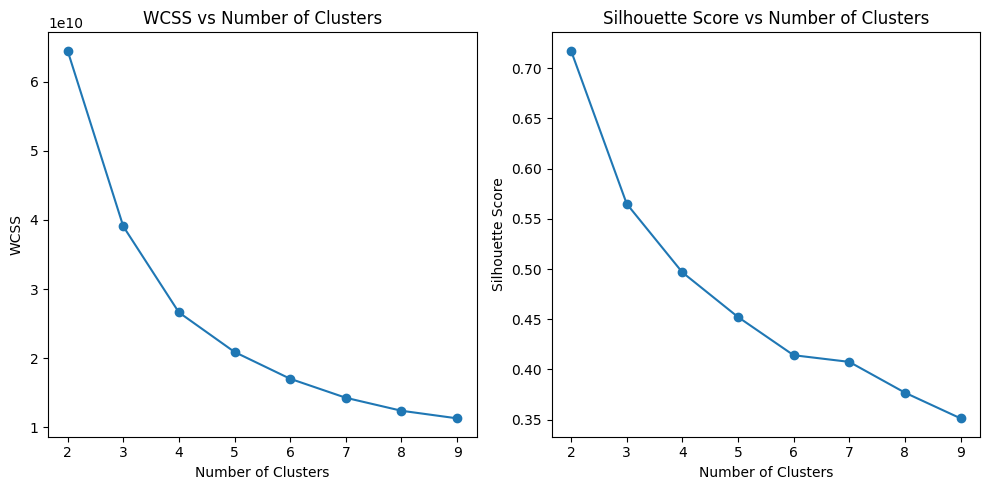

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(k_values, wcss_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('WCSS vs Number of Clusters')

plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')

plt.tight_layout()
plt.show()

In [12]:
# looks like two is the best
kmeans = KMeans(n_clusters=2,random_state=42)
kmeans.fit(imp_cluster_data)
with_clustering = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [13]:
centroids = kmeans.cluster_centers_

# Convert centroids to a DataFrame for easier analysis
centroid_df = pd.DataFrame(centroids, columns=imp_cluster_data.columns)

# Print or visualize the centroids
print(centroid_df)

    longitude   latitude  housing_median_age  total_rooms  total_bedrooms  \
0 -119.296743  35.408589           16.663429  7869.806286     1503.883737   
1 -119.594992  35.652546           29.748968  2150.872896      448.377536   

    population   households  median_income  latitude_rad  longitude_rad  \
0  3849.484571  1378.341143       4.563865      0.617996      -2.082121   
1  1200.912758   418.126098       3.806452      0.622254      -2.087326   

   distance_to_nearest_big_city_km  
0                         0.987516  
1                         0.917302  


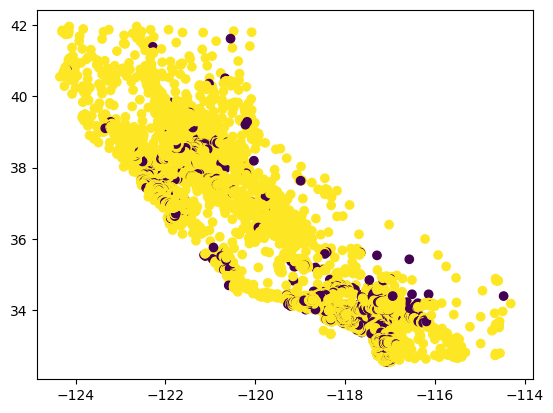

In [16]:
plt.scatter(x=clustered_housing_data['longitude'],y=clustered_housing_data['latitude'],c=clustered_housing_data['cluster_labels'])

In [15]:
# rerunning Random Forest with the cluster assignments
clustered_housing_data = housing_data.copy()
clustered_housing_data['cluster_labels'] = with_clustering
clustered_housing_data['lat_lon_interaction'] = clustered_housing_data['latitude'] * clustered_housing_data['longitude']
clustered_housing_data.drop(['latitude_rad','longitude_rad'],axis=1,inplace=True)
clustered_housing_data

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,nearest_city,nearest_big_city,distance_to_nearest_big_city_km,cluster_labels,lat_lon_interaction
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,Berkeley,Oakland,0.167070,1,-4630.0724
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,Orinda,Oakland,0.146619,0,-4627.2492
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,Piedmont,Oakland,0.107190,1,-4626.7840
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,Berkeley,Oakland,0.097585,1,-4627.1625
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,Berkeley,Oakland,0.097585,1,-4627.1625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND,Nevada City,Sacramento,1.912064,1,-4780.6332
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND,Oroville,Sacramento,1.847369,1,-4786.5829
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND,Nevada City,Sacramento,1.730523,1,-4779.7046
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND,Oroville,Sacramento,1.680981,1,-4783.6476


In [17]:
clustered_housing_data

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,nearest_city,nearest_big_city,distance_to_nearest_big_city_km,cluster_labels,lat_lon_interaction
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,Berkeley,Oakland,0.167070,1,-4630.0724
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,Orinda,Oakland,0.146619,0,-4627.2492
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,Piedmont,Oakland,0.107190,1,-4626.7840
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,Berkeley,Oakland,0.097585,1,-4627.1625
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,Berkeley,Oakland,0.097585,1,-4627.1625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND,Nevada City,Sacramento,1.912064,1,-4780.6332
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND,Oroville,Sacramento,1.847369,1,-4786.5829
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND,Nevada City,Sacramento,1.730523,1,-4779.7046
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND,Oroville,Sacramento,1.680981,1,-4783.6476


In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

X = clustered_housing_data.drop('median_house_value', axis=1)
y = clustered_housing_data['median_house_value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

numeric_features = X.select_dtypes(include=['int64', 'float64','int32']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Create transformers for numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine transformers into a preprocessor with ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

rf = RandomForestRegressor(random_state=42)

rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', rf)])
rf_pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'distance_to_nearest_big_city_km', 'cluster_labels',
       'lat_lon_interaction'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['ocean_proximity', 'nearest_city', 'nearest_big_city'], dtype='object'))])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [19]:
predictions = rf_pipeline.predict(X_test)
predictions_train = rf_pipeline.predict(X_train)

In [20]:
print(np.sqrt(mean_squared_error(y_train, predictions_train)))
np.sqrt(mean_squared_error(y_test, predictions))

17903.477976957394


47783.838084622665

In [21]:
clustered_housing_data

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,nearest_city,nearest_big_city,distance_to_nearest_big_city_km,cluster_labels,lat_lon_interaction
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,Berkeley,Oakland,0.167070,1,-4630.0724
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,Orinda,Oakland,0.146619,0,-4627.2492
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,Piedmont,Oakland,0.107190,1,-4626.7840
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,Berkeley,Oakland,0.097585,1,-4627.1625
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,Berkeley,Oakland,0.097585,1,-4627.1625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND,Nevada City,Sacramento,1.912064,1,-4780.6332
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND,Oroville,Sacramento,1.847369,1,-4786.5829
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND,Nevada City,Sacramento,1.730523,1,-4779.7046
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND,Oroville,Sacramento,1.680981,1,-4783.6476


In [ ]:
# model errors compared

# no interaction or regularization
# 18009.65928001054
# 48019.01718255117

# with interaction no regularization
# 17891.5293999297
# 47796.31049541243

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

X_tuning_data = X_train[0:4000]
y_tuning_data = y_train[0:4000]

numeric_features = X.select_dtypes(include=['int64', 'float64','int32']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Create transformers for numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine transformers into a preprocessor with ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

rf = RandomForestRegressor(random_state=42)

rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', rf)])

param_grid = {
    'regressor__max_depth': [None, 10, 20],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
}

grid_search = GridSearchCV(estimator=rf_pipeline, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_tuning_data, y_tuning_data)

print("Best parameters:", grid_search.best_params_)

Best parameters: {'regressor__max_depth': None, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 5}


In [24]:
# rerunning with the grid search tuned hyperparameters
X = clustered_housing_data.drop('median_house_value', axis=1)
y = clustered_housing_data['median_house_value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

numeric_features = X.select_dtypes(include=['int64', 'float64','int32']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Create transformers for numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine transformers into a preprocessor with ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

rf_tuned = RandomForestRegressor(random_state=42, min_samples_split=5)

rf_pipeline_tuned = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', rf_tuned)])
rf_pipeline_tuned.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'distance_to_nearest_big_city_km', 'cluster_labels',
       'lat_lon_interaction'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['ocean_proximity', 'nearest_city', 'nearest_big_city'], dtype='object'))])),
                ('regressor',
                 RandomForestRegressor(min_samples_split=5, random_state=42))])

In [25]:
predictions_tuned = rf_pipeline_tuned.predict(X_test)
predictions_train_tuned = rf_pipeline_tuned.predict(X_train)

In [26]:
print(np.sqrt(mean_squared_error(y_train, predictions_train_tuned)))
np.sqrt(mean_squared_error(y_test, predictions_tuned))

21517.28607087208


47842.029558095295

100%|===================| 15477/15480 [20:46<00:00]       

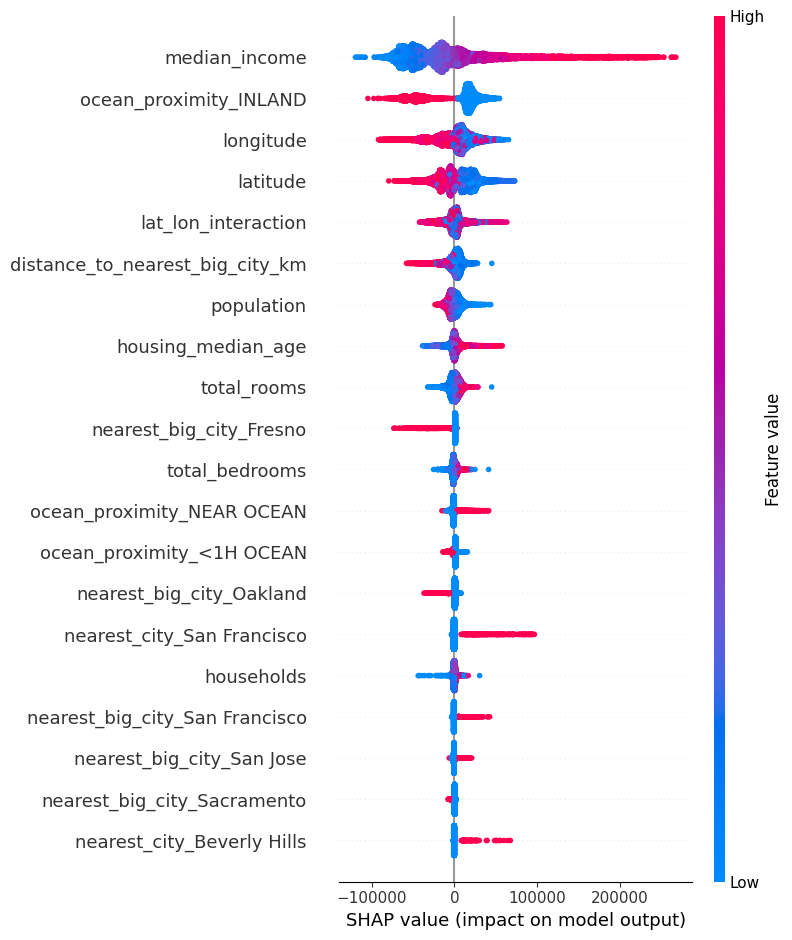

In [60]:
import shap

# Transform the data using the preprocessor and convert to dense matrix
X_train_transformed = rf_pipeline_tuned.named_steps['preprocessor'].transform(X_train).toarray()

# Initialize SHAP explainer with the trained model and transformed feature data
explainer = shap.Explainer(rf_pipeline_tuned.named_steps['regressor'], X_train_transformed)

# Compute SHAP values
shap_values = explainer.shap_values(X_train_transformed, check_additivity=False)

# Visualize SHAP summary plot
shap.summary_plot(shap_values, X_train_transformed, feature_names=new_feature_names)
